### IST 718 Week 4 Exercises
Using anonymous data from my job, I'll analyze the time series for disbursments between January and September 2018, trying to forecast disbursments for October through December. I'll then compare these forecasts to the actual disbursements. 

In [1]:
# Import packages 
import pandas as pd
from pandas import datetime
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [2]:
# Define a datetime parser that will convert date column to datetime
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

# Load Time Series data. 
df = pd.read_csv('TimeSeries.csv', parse_dates=[0], date_parser=parser)

print(df.shape)
print(df.head())

(252, 3)
  disbursement_date  disbursement_amount  disbursements
0        2018-01-02              20083.8              6
1        2018-01-03              33903.0             13
2        2018-01-04              25543.4              9
3        2018-01-05              24190.3              8
4        2018-01-08              85065.0             25


We have 252 observations over three columns. For this exercise, however, I'm going to focus on the disbursement_amount columun. The disbursements column will be dropped.  
Also, will build to data sets, one spanning from January to September, which will be used to create the model; the second, from October to December, will be the test set. 

In [3]:
# Drop disbursments column. The disbursement_date column will then be set as the index. 
df2 = df.iloc[:, 0:2]
df2 = df2.set_index('disbursement_date')

Now that the dataset has been altered, we'll create two more data sets, splitting the original data frame. 

In [4]:
# Split the data into jan_sep and oct_dec. 
jan_sep = df2.loc[:'2018-10-01']
oct_dec = df2.loc['2018-10-01':]

Let's do some quick summarisation. We should check the distributions for both disbursement_amount and disbursements by month to check how much the data fluctuates.  
We should also plot how the data fluctuates on a daily basis. 

In [5]:
# Let's create a new variable, month, that will allow us to check distributions across the year.
df['month'] = df['disbursement_date'].dt.month

# Now we'll check the average disbursement_amount and disbursements per day by month. 
print(df.groupby('month')['disbursement_amount'].mean())
print(df.groupby('month')['disbursements'].mean())

month
1     28597.754545
2     36989.360000
3     39065.988000
4     44983.435000
5     31397.940909
6     28850.195000
7     22706.777727
8     32021.035217
9     39435.748500
10    43188.745909
11    48751.688571
12    39813.864000
Name: disbursement_amount, dtype: float64
month
1      7.772727
2      8.800000
3      8.800000
4     12.800000
5     10.681818
6      9.000000
7      7.500000
8     11.260870
9     14.050000
10    15.363636
11    17.761905
12    13.200000
Name: disbursements, dtype: float64


Overall, there seems to be a an increasing trend line up until April. Both disbursements and disbursement amount hit a valley in July and then begin to grow unitl a new peak in November. Overall, seems like there's a solid seasonal pattern. 

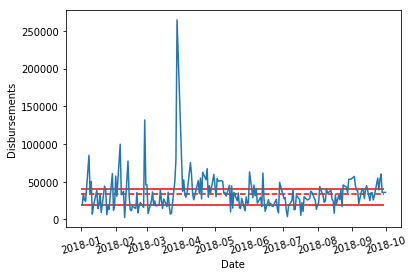

<Figure size 1440x720 with 0 Axes>

In [6]:
# Plot both time series for disbursements
sns.lineplot(x=jan_sep.index, y='disbursement_amount', data=jan_sep)
_ = plt.hlines(y=jan_sep['disbursement_amount'].mean(), xmin='2018-01-01', xmax='2018-09-30', linestyle='dashed', color='red')
_ = plt.hlines(y=jan_sep['disbursement_amount'].quantile(0.75), xmin='2018-01-01', xmax='2018-09-30', linestyle='solid', color='red')
_ = plt.hlines(y=jan_sep['disbursement_amount'].quantile(0.25), xmin='2018-01-01', xmax='2018-09-30', linestyle='solid', color='red')
_ = plt.xlabel('Date')
_ = plt.ylabel('Disbursements')
_ = plt.xticks(rotation=15)
_ = plt.figure(figsize=(20,10))
plt.show()

This graph is really interesting! We can see that, between April and September, the disbursement amount for each day is within the 25th and 75th percentile. But before April, we see that there are some very atypical disbursement observations, with the end of March featuring a total number of 250,000 Peruvian Soles (~84,000 US Dollars) being disbursed in a single day. 

#### Forecasting
We now have a good idea of how disbursements and disbursement amounts have changed through the year. We'll now use ARIMA to forecast the last three months of 2018. 

C:\Users\malon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\malon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               ARIMA Model Results                               
Dep. Variable:     D.disbursement_amount   No. Observations:                  189
Model:                    ARIMA(5, 1, 0)   Log Likelihood               -2181.782
Method:                          css-mle   S.D. of innovations          24887.910
Date:                   Mon, 04 Feb 2019   AIC                           4377.565
Time:                           21:27:06   BIC                           4400.257
Sample:                                1   HQIC                          4386.758
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          48.9476    561.485      0.087      0.931   -1051.543    1149.438
ar.L1.D.disbursement_amount    -0.7350      0.071    -10

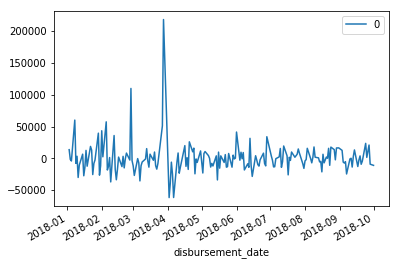

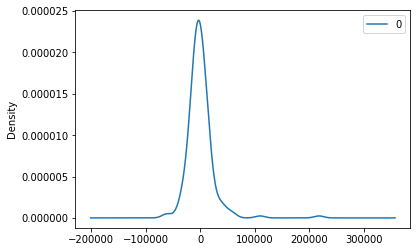

                   0
count     189.000000
mean      172.759255
std     25010.786538
min    -61265.605093
25%    -11773.682576
50%     -2152.153697
75%      7783.977621
max    217597.420219


In [28]:
# Build the ARIMA model, fit it, and print the summary and plots. 
model = ARIMA(jan_sep, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Looking at the results, we can see that constant has a very high p-value. The AIC is also high, reaching 4,355. But, looking at the first plot, the residuals seem to be very tightly knit, with exception to the spike that may be attributed to the large spike in the data set. The KDE plot shows, also, that the residual errors are following a Gaussian curve and centering around zero.  

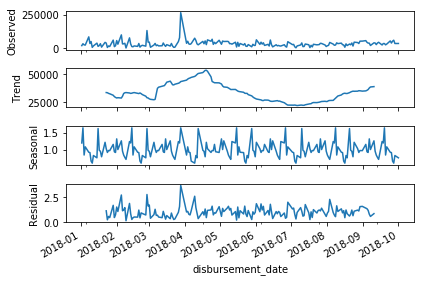

In [8]:
# Decompose the graph to remove noise and identify if there's a seasonal trend. 
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(jan_sep, model='multiplicative', freq=30)
fig = result.plot()
plt.show(fig)

We can clearly see that there is a seasonal trend in the second graph. The third graph also shos a spike occuring twice about every three weeks, which is really interesting and something I did not expect.  
Time to perform a seasonal forecast given these results. 

In [73]:
# Create an array with forecast for the next days of the year
forecast = model_fit.forecast(steps=63)[0]
forecast = pd.Series(forecast)

# Set the index aside, add to forecast, and merge
series_index = oct_dec.index
forecast.index = series_index

# Concatenate oct_dec with forecast and calculate RMSE
results = pd.concat([oct_dec, forecast], axis=1, ignore_index=True)
results.columns = ['Actual', 'Forecast']
print(results.head())
print(results.tail())

                     Actual      Forecast
disbursement_date                        
2018-10-01         35949.38  40640.756739
2018-10-02         47378.04  42242.747791
2018-10-03         37836.40  48358.522774
2018-10-04         52684.84  46068.385533
2018-10-05         55037.06  42428.151327
                     Actual      Forecast
disbursement_date                        
2018-12-24         73481.59  46114.046170
2018-12-26         54235.28  46162.974537
2018-12-27         50162.38  46211.918121
2018-12-28         36949.42  46260.874845
2018-12-31         40620.77  46309.832495


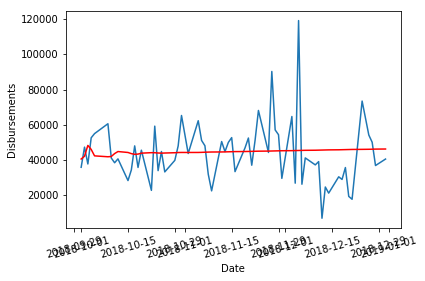

<Figure size 1440x720 with 0 Axes>

In [72]:
# Plot the actual disbursements and the forecasts
sns.lineplot(x=results.index, y='Actual', data=results)
sns.lineplot(x=results.index, y='Forecast', data=results, color='red', linestyle='dashed')
_ = plt.xlabel('Date')
_ = plt.ylabel('Disbursements')
_ = plt.xticks(rotation=15)
_ = plt.figure(figsize=(20,10))
plt.show()

There's not much this forecast tells us. There is a trend showing that the amount disbursed is increasing but there is no sign that the forecast follows the expected pattern. Perhaps, to get a result closer to reality, additional parameters need to be set; otherwise, this model is useless. 